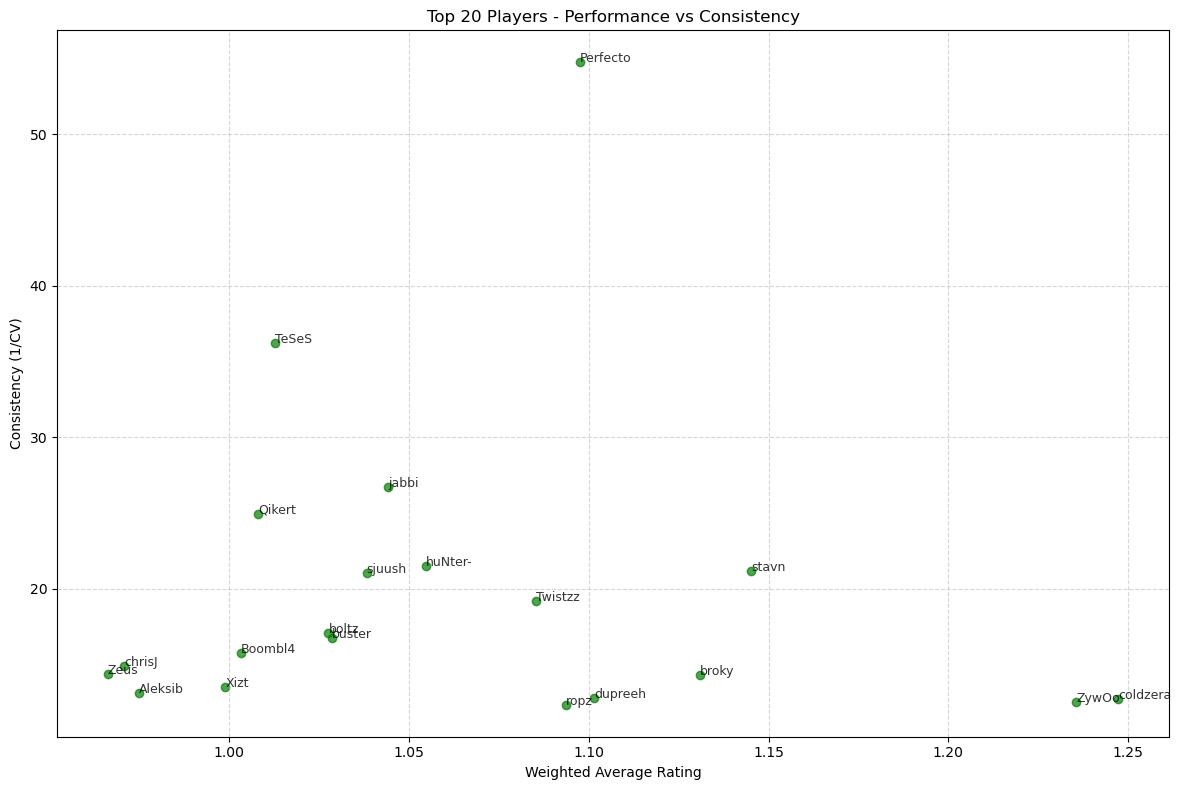

In [108]:
#Major stat for Git Hub
#Consistency vs Performance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

min_rounds = 1000

#Make a clean dataset (Without Challenger Stages)

data = pd.read_csv("C:/Users/Zolaky/Downloads/major-stats.csv") 
clean_data = data[~data["event"].str.contains("Challengers Stage")].copy()

# Securing the columns rounds and rating to be integers or floats

clean_data["rating"] = pd.to_numeric(clean_data["rating"], errors="coerce")
clean_data["rounds"] = pd.to_numeric(clean_data["rounds"], errors="coerce")

#Calculating the total number of rounds per player

total_rounds = clean_data.groupby("name")["rounds"].sum().reset_index(name="total_rounds")

#Calculating the weighted average rating for every player

weighted_average_ratings = clean_data.groupby("name", group_keys=False)[["rating","rounds"]].apply(
    lambda g: (g["rating"] * g["rounds"]).sum() / g["rounds"].sum()
).reset_index(name="weighted_ratings")

#Calculating the weighted variance of player ratings the weighted standard deviation

weighted_variance_and_std = clean_data.groupby("name", group_keys=False)[["rating","rounds"]].apply(
    lambda g: (
        (g["rounds"] * (g["rating"] - ( (g["rating"] * g["rounds"]).sum() / g["rounds"].sum() ))**2).sum() / g["rounds"].sum()
    )
).reset_index(name="weighted_variance")

weighted_variance_and_std["weighted_std"] = np.sqrt(
    weighted_variance_and_std["weighted_variance"].clip(lower=0)
)

final_stats = weighted_variance_and_std.merge(weighted_average_ratings,  on="name", how="left")
final_stats = final_stats.merge(total_rounds, on="name", how="left")

#Calculating the coefficient of variation

final_stats["cv"] = final_stats["weighted_std"] / final_stats["weighted_ratings"]
final_stats.loc[final_stats["weighted_ratings"] == 0, "cv"] = np.nan

#Calculating the consistency for each player

final_stats["consistency"] = 1 / final_stats["cv"]


#Replacing infinite values with NaN

final_stats.replace([np.inf, -np.inf], np.nan, inplace=True)

##Filtering the players with a low total number of rounds played

final_stats = final_stats[final_stats["total_rounds"] >= min_rounds]

#Rounding the values

cols = ["weighted_ratings", "weighted_variance", "weighted_std", "cv", "consistency"]
final_stats[cols] = final_stats[cols].round(4)


#Top 20

top20 = final_stats.sort_values(
    ["consistency", "weighted_ratings"], ascending=[False, False]
).head(20)

#Graph

plt.figure(figsize=(12,8))
plt.scatter(top20["weighted_ratings"], top20["consistency"], color="green", alpha=0.7)

plt.xlabel("Weighted Average Rating")
plt.ylabel("Consistency (1/CV)")
plt.title("Top 20 Players - Performance vs Consistency")

# Adding names
for i, row in top20.iterrows():
    plt.annotate(row["name"],
                 (row["weighted_ratings"], row["consistency"]),
                 fontsize=9,
                 alpha=0.8)

plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
